In [1]:
import numpy as np

import pyNN.nest as sim
from pyNN.random import NumpyRNG
from pyNN.random import RandomDistribution as rnd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D

from lmfit.models import GaussianModel
import lmfit
from lmfit import Model, Parameters

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


/home/hugo/.local/lib/python3.7/site-packages/pyNN/nest/__init__.py:55: UserWarning: Unable to install NEST extensions. Certain models may not be available.
Further details: DictError in SLIInterpreter::execute: Key '/Install' does not exist in dictionary.
  warnings.warn("Unable to install NEST extensions. Certain models may not be available.\nFurther details: {}".format(err))


# Scanning STDP shapes
It's pretty much the same 3D scan as we did in 2018-12-18_Grid_search_STDP_times, here we'll scan for coefficients of amplitudes and tau constant, as biological STDP is not symetrical, even when hebbian.

# Utility functions

In [2]:
from pyNN.space import *


class RingTopology(BaseStructure):
    parameter_names = 'radius'

    def __init__(self, radius):
        self.radius = radius

    def generate_positions(self, n):
        return np.array([
            np.cos(np.linspace(0, 2*np.pi, n))+(self.radius-1),
            np.sin(np.linspace(0, 2*np.pi, n))+(self.radius-1),
            np.zeros(n)
        ])
        # must return a 3xn numpy array

In [3]:
def tuning_function(x, j, B, fmax):  # von mises
    N = len(x)
    if B == np.inf:
        VM = np.ones_like(x)
    else:
        VM = np.exp((np.cos(2.*np.pi*(x-j)/N)-1.)/4/(B*np.pi/180)**2)
    #VM /= VM.sum(axis=0)
    return fmax * VM


def fit_gaussian(popsize, spike_array, seq_nbr=None):
    '''
    calculates a spike array gaussian lmfit profile and plots it
    '''

    # fit the gaussian
    x = np.linspace(0, popsize, popsize)
    y = spike_array
    N = len(spike_array)

    mod = Model(tuning_function)
    pars = Parameters()
    pars.add_many(('j', y.argmax(), True,  0.0, N), ('B', 15., True,  0.1, 360),
                  ('fmax', y.max(), True,  0.0, 200.))

    out = mod.fit(y, pars, x=x, nan_policy='omit')
    sigma = out.best_values['B']

    return sigma


def cut_spiketrain(array, window):
    '''
    Cut a spiketrain array between window*500 and window+1 *500
    we use it to only visualize a specific time window of the network
    '''
    spiketrain_len = []
    for spiketrain in np.asarray(array.spiketrains):
        spiketrain_array = np.array(spiketrain, dtype=float)

        spiketrain_cut = np.where(
            (spiketrain_array > window*1250) & (spiketrain_array < (window+1)*1250))[0]

        spiketrain_len.append(len(spiketrain_cut))

    spikelen_array = np.asarray(spiketrain_len)
    return spikelen_array

In [4]:
def SuperScanner(SpikesP, SpikesE, SpikesI,
                 popsize, simtime):

    sigma_zero = fit_gaussian(popsize, cut_spiketrain(SpikesE, 0), seq_nbr=1)
    sigma_one = fit_gaussian(popsize, cut_spiketrain(SpikesE, 1), seq_nbr=2)
    sigma_two = fit_gaussian(popsize, cut_spiketrain(SpikesE, 2), seq_nbr=3)
    sigma_f = fit_gaussian(popsize, cut_spiketrain(SpikesE, 3), seq_nbr=4)

    return [sigma_zero, sigma_one, sigma_two, sigma_f]

# Simulation and plotting function

In [5]:
def run_simulation(causal_ratio, anticausal_ratio,
                   causal_sym_ratio, anticausal_sym_ratio,
                   t_causal_ratio, t_anticausal_ratio,
                   t_causal_sym_ratio, t_anticausal_sym_ratio):
    def vary_angle(t):
        n_pop = 60
        shift = 40
        noise = .3

        angle = 1. * np.arange(n_pop)
        rates = tuning_function(
            angle, (t*shift)+(angle_input)/180.*n_pop, b_theta, rate_gain)
        rates = (1-noise)*rates + noise * rate_gain

        for i, cell in enumerate(input_pop):
            cell.set_parameters(rate=rates[i])

        return t + simtime/4

    stdp_weight_init = .1
    stdp_max_w = 2 * stdp_weight_init
    normal_weights = stdp_weight_init

    delays = rnd('normal_clipped', mu=3, sigma=5, low=0.1,
                 high=5,
                 rng=rng)

    causal_hebian_timing_dependence = sim.SpikePairRule(tau_plus=30.*t_causal_ratio,
                                                        tau_minus=30.,
                                                        A_plus=.025*causal_ratio,
                                                        A_minus=.025)
    anticausal_hebian_timing_dependence = sim.SpikePairRule(tau_plus=30.*t_anticausal_ratio,
                                                            tau_minus=30.,
                                                            A_plus=-.025*anticausal_ratio,
                                                            A_minus=-.025)
    causal_sym_timing_dependence = sim.SpikePairRule(tau_plus=30.*t_causal_sym_ratio,
                                                     tau_minus=30.,
                                                     A_plus=.025*causal_sym_ratio,
                                                     A_minus=-.025)
    anticausal_sym_timing_dependence = sim.SpikePairRule(tau_plus=30.*t_anticausal_sym_ratio,
                                                         tau_minus=30.,
                                                         A_plus=-.025*anticausal_sym_ratio,
                                                         A_minus=.025)

    sim.setup(timestep=.1, threads=8)

    exc = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                         initial_values={"v": neuron_parameters["v_reset"]},
                         structure=RingTopology(radius=2),
                         label="Neurones Exictateurs")
    inh = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                         initial_values={"v": neuron_parameters["v_reset"]},
                         structure=RingTopology(radius=2),
                         label="Neurones Inhibiteurs")
    input_pop = sim.Population(n_pop,
                               sim.SpikeSourcePoisson(
                                   rate=1500, duration=simtime, start=0),
                               label="Entree Orientation")

    # INPUT STDP
    in_mult = 4
    # input to exc, causal hebbian
    in_causal_STDP_syn = sim.STDPMechanism(
        timing_dependence=causal_hebian_timing_dependence,
        weight_dependence=sim.MultiplicativeWeightDependence(
            w_min=0, w_max=in_mult*stdp_max_w),
        weight=in_mult*stdp_weight_init,
        delay=delays,
        dendritic_delay_fraction=1.)
    # input to inh, anticausal hebbian
    in_anticausal_STDP_syn = sim.STDPMechanism(
        timing_dependence=anticausal_hebian_timing_dependence,
        weight_dependence=sim.MultiplicativeWeightDependence(
            w_min=0, w_max=in_mult*stdp_max_w),
        weight=in_mult*stdp_weight_init,
        delay=delays,
        dendritic_delay_fraction=1.)

    # CAUSAL STDP
    # syn exc_inh, hebbian causality
    causal_STDP_syn = sim.STDPMechanism(
        timing_dependence=causal_hebian_timing_dependence,
        weight_dependence=sim.MultiplicativeWeightDependence(
            w_min=0, w_max=stdp_max_w),
        weight=stdp_weight_init,
        delay=delays,
        dendritic_delay_fraction=1.)

    # ANTICAUSAL STDP
    # syn inh exc, makes the inhibitory fire when exc is not firing
    inh_anticausal_STDP_syn = sim.STDPMechanism(
        timing_dependence=anticausal_hebian_timing_dependence,
        weight_dependence=sim.MultiplicativeWeightDependence(
            w_min=0, w_max=-stdp_max_w),
        weight=-stdp_weight_init,
        delay=delays,
        dendritic_delay_fraction=1.)

    # SYMETRIC POSITIVE STDP
    # syn exc exc, reinforcing
    sim_plus_STDP_syn = sim.STDPMechanism(
        timing_dependence=causal_sym_timing_dependence,
        weight_dependence=sim.MultiplicativeWeightDependence(
            w_min=0, w_max=stdp_max_w),
        weight=stdp_weight_init,
        delay=delays,
        dendritic_delay_fraction=1.)
    # syn inh inh, reinforcing inhibition
    inh_sim_plus_STDP_syn = sim.STDPMechanism(
        timing_dependence=causal_sym_timing_dependence,
        weight_dependence=sim.MultiplicativeWeightDependence(
            w_min=0, w_max=-stdp_max_w),
        weight=-stdp_weight_init,
        delay=delays,
        dendritic_delay_fraction=1.)

    # Intras
    syn_exc_exc = sim.Projection(exc, exc,
                                 connector=sim.DistanceDependentProbabilityConnector("exp(2*-d)",
                                                                                     allow_self_connections=False),
                                 synapse_type=sim_plus_STDP_syn)
    syn_inh_inh = sim.Projection(inh, inh,
                                 connector=sim.DistanceDependentProbabilityConnector("exp(2*-d)",
                                                                                     allow_self_connections=False),
                                 synapse_type=inh_sim_plus_STDP_syn)

    # Inters
    syn_exc_inh = sim.Projection(exc, inh,
                                 connector=sim.AllToAllConnector(
                                     allow_self_connections=False),
                                 synapse_type=causal_STDP_syn)
    syn_inh_exc = sim.Projection(inh, exc,
                                 connector=sim.AllToAllConnector(
                                     allow_self_connections=False),
                                 synapse_type=inh_anticausal_STDP_syn)

    # Input
    syn_inp_exc = sim.Projection(input_pop, exc,
                                 connector=sim.OneToOneConnector(),
                                 synapse_type=in_causal_STDP_syn)
    syn_inp_inh = sim.Projection(input_pop, inh,
                                 connector=sim.OneToOneConnector(),
                                 synapse_type=in_anticausal_STDP_syn)

    exc.record('spikes')
    inh.record('spikes')
    input_pop.record('spikes')
    sim.run(simtime, callbacks=[vary_angle])
    sim.end()

    exc_data = exc.get_data().segments[0]
    inh_data = inh.get_data().segments[0]
    inp_data = input_pop.get_data().segments[0]

    final_b_theta = SuperScanner(inp_data, exc_data, inh_data,
                                 60, simtime)[-1]
    sim.reset()

    return final_b_theta

In [6]:
def triD_plot(x, y, z,
              tx, ty, tz):

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    tri = ax.plot_trisurf(x, y, z,
                          #c=np.linspace(min(sigmas_f), max(sigmas_f), sigmas_f.shape[0]),
                          cmap=plt.cm.viridis,
                          linewidth=0)

    ax.set_zlabel(tz, fontsize=20)
    ax.set_xlabel(tx, fontsize=20)
    ax.set_ylabel(ty, fontsize=20)

    ax.xaxis._axinfo["grid"]["color"] = (1, 1, 1, 0)
    ax.yaxis._axinfo["grid"]["color"] = (1, 1, 1, 0)
    #ax.zaxis._axinfo["grid"]["color"] = (1,1,1,0)
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    plt.colorbar(tri)
    ax.set_title('Gradient des performances du réseau')
    ax.view_init(elev=90, azim=0)

    return fig, ax

# Simulation time

In [7]:
n_pop = 60
neuron_parameters = {'cm': .5,  # nF - McCormick
                     'e_rev_E': 0.0,  # mV - McCormick but default values
                     'e_rev_I': -70.0,  # mV - McCormick but default values
                     'tau_m': 30,  # ms - Markram
                     'tau_refrac': 1.5,  # ms - McCormick
                     'tau_syn_E': 0.25,  # ms -McCormick
                     'tau_syn_I': 0.75,  # ms - McCormick
                     'v_reset': -56.5,  # mV - McCormick
                     'v_rest': -65.5,  # mV - McCormick
                     'v_thresh': -52.5,  # mV - McCormick
                     }

simtime = 5000
rng = sim.NumpyRNG(seed=42)

rate_gain = 20.  # multiplier for the rates
angle_input = 40  # degrees
b_theta = 15  # degrees

# First scan, causal and anticausal amp ratios

In [8]:
%matplotlib notebook

100%|██████████| 400/400 [17:59<00:00,  2.74s/it] 


<IPython.core.display.Javascript object>


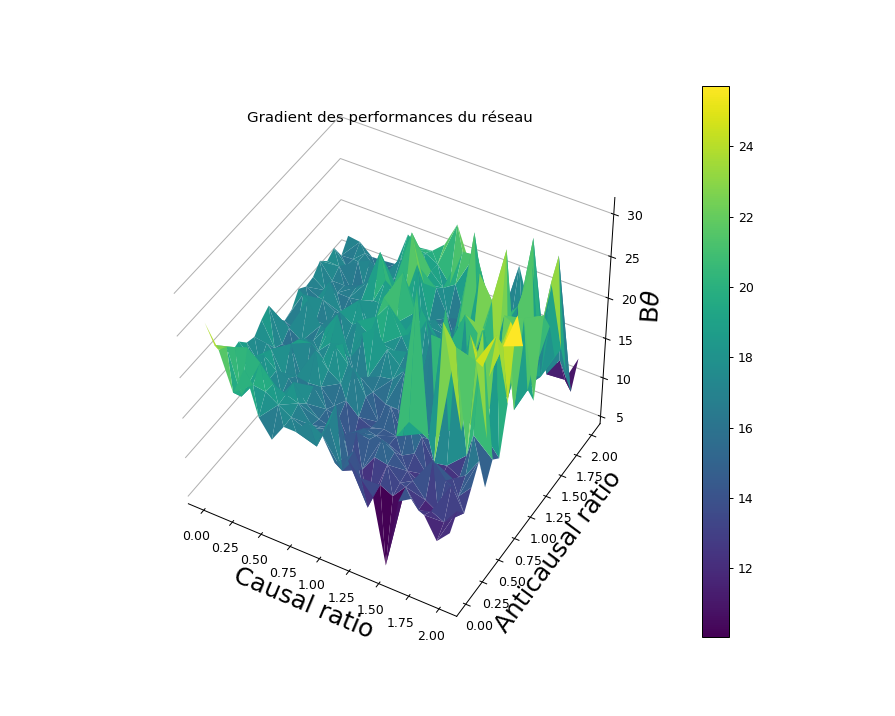

In [35]:
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

scan_size = 8

# ratios are applied as a multiplier of the positive part of STDP
# ie tau_plus or A_plus
parameters_dico = {'causal_ratio': np.linspace(.01, 2, scan_size),
                   'anticausal_ratio': np.linspace(.01, 2, scan_size),
                   'causal_sym_ratio': np.array([1]),
                   'anticausal_sym_ratio': np.array([1]),
                   't_causal_ratio': np.array([1]),
                   't_anticausal_ratio': np.array([1]),
                   't_causal_sym_ratio': np.array([1]),
                   't_anticausal_sym_ratio': np.array([1])
                   }
grid = ParameterGrid(parameters_dico)

scan_output = []
for combination in tqdm(grid):
    final_b_theta = run_simulation(causal_ratio=combination['causal_ratio'],
                                   anticausal_ratio=combination['anticausal_ratio'],
                                   causal_sym_ratio=combination['causal_sym_ratio'],
                                   anticausal_sym_ratio=combination['anticausal_sym_ratio'],
                                   t_causal_ratio=combination['t_causal_ratio'],
                                   t_anticausal_ratio=combination['t_anticausal_ratio'],
                                   t_causal_sym_ratio=combination['t_causal_sym_ratio'],
                                   t_anticausal_sym_ratio=combination['t_anticausal_sym_ratio'])
    scan_output.append([final_b_theta, combination])

b_fs, causal_ratios, anticausal_ratios = [], [], []
for scan in scan_output:
    b_fs.append(scan[0])
    causal_ratios.append(scan[1]['causal_ratio'])
    anticausal_ratios.append(scan[1]['anticausal_ratio'])

triD_plot(causal_ratios, anticausal_ratios, b_fs,
          'Causal ratio', 'Anticausal ratio', r'B$\theta$')
plt.show()

# Second scan, causal sym ratio and anticausal sym ratio (amp also)

In [ ]:
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

scan_size = 8

# ratios are applied as a multiplier of the positive part of STDP
# ie tau_plus or A_plus
parameters_dico = {'causal_ratio': np.array([1.5]),
                   'anticausal_ratio': np.array([0.3]),
                   'causal_sym_ratio': np.linspace(.01, 2, scan_size),
                   'anticausal_sym_ratio': np.linspace(.01, 2, scan_size),
                   't_causal_ratio': np.array([1]),
                   't_anticausal_ratio': np.array([1]),
                   't_causal_sym_ratio': np.array([1]),
                   't_anticausal_sym_ratio': np.array([1])
                   }
grid = ParameterGrid(parameters_dico)

scan_output = []
for combination in tqdm(grid):
    final_b_theta = run_simulation(causal_ratio=combination['causal_ratio'],
                                   anticausal_ratio=combination['anticausal_ratio'],
                                   causal_sym_ratio=combination['causal_sym_ratio'],
                                   anticausal_sym_ratio=combination['anticausal_sym_ratio'],
                                   t_causal_ratio=combination['t_causal_ratio'],
                                   t_anticausal_ratio=combination['t_anticausal_ratio'],
                                   t_causal_sym_ratio=combination['t_causal_sym_ratio'],
                                   t_anticausal_sym_ratio=combination['t_anticausal_sym_ratio'])
    scan_output.append([final_b_theta, combination])

<IPython.core.display.Javascript object>


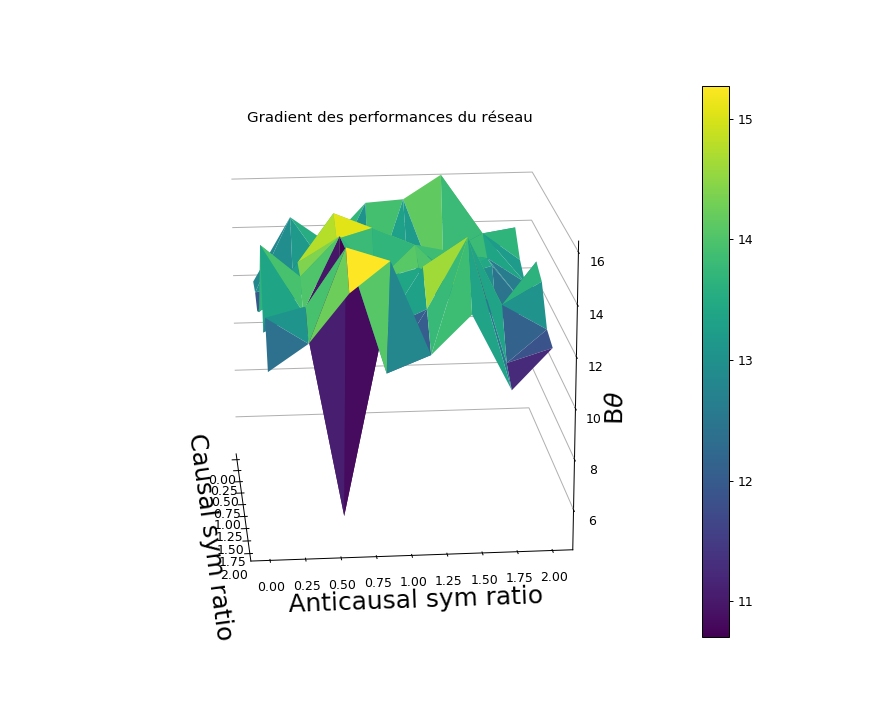

In [12]:
b_fs, causal_sym_ratios, anticausal_sym_ratios = [], [], []
for scan in scan_output:
    b_fs.append(scan[0])
    causal_sym_ratios.append(scan[1]['causal_sym_ratio'])
    anticausal_sym_ratios.append(scan[1]['anticausal_sym_ratio'])

triD_plot(causal_sym_ratios, anticausal_sym_ratios, b_fs,
          'Causal sym ratio', 'Anticausal sym ratio', r'B$\theta$')
plt.show()

# Scan 3,  taus pour causal et anticausal

100%|██████████| 64/64 [03:12<00:00,  2.85s/it]


<IPython.core.display.Javascript object>


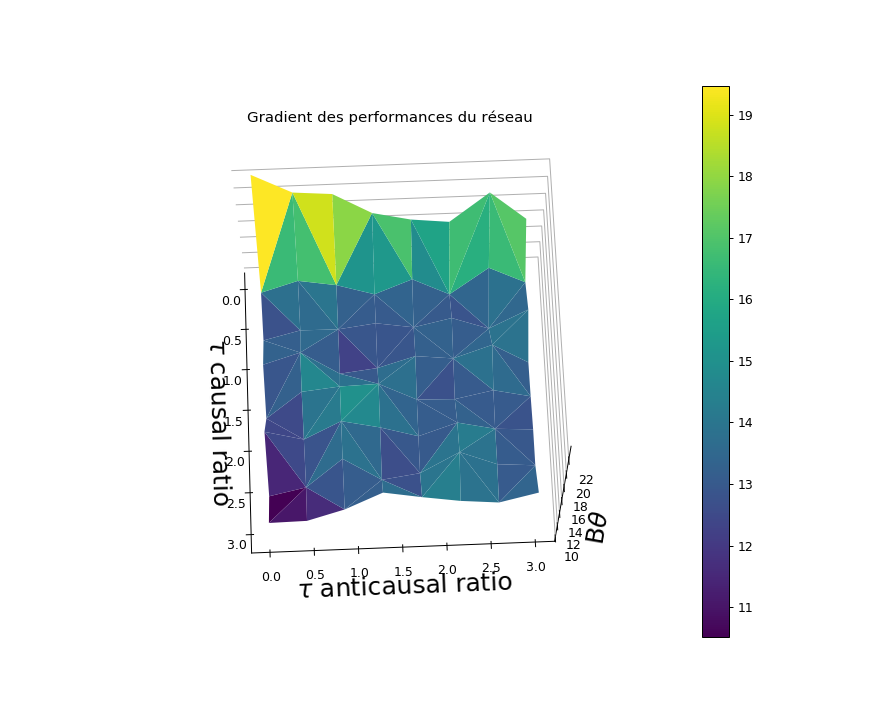

In [31]:
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

scan_size = 8

# ratios are applied as a multiplier of the positive part of STDP
# ie tau_plus or A_plus
parameters_dico = {'causal_ratio': np.array([1.5]),
                   'anticausal_ratio': np.array([0.3]),
                   'causal_sym_ratio': np.array([1]),
                   'anticausal_sym_ratio': np.array([1.75]), 
                   't_causal_ratio': np.linspace(.01, 3, scan_size),
                   't_anticausal_ratio': np.linspace(.01, 3, scan_size),
                   't_causal_sym_ratio': np.array([1]),
                   't_anticausal_sym_ratio': np.array([1])
                   }
grid = ParameterGrid(parameters_dico)

scan_output = []
for combination in tqdm(grid):
    final_b_theta = run_simulation(causal_ratio=combination['causal_ratio'],
                                   anticausal_ratio=combination['anticausal_ratio'],
                                   causal_sym_ratio=combination['causal_sym_ratio'],
                                   anticausal_sym_ratio=combination['anticausal_sym_ratio'],
                                   t_causal_ratio=combination['t_causal_ratio'],
                                   t_anticausal_ratio=combination['t_anticausal_ratio'],
                                   t_causal_sym_ratio=combination['t_causal_sym_ratio'],
                                   t_anticausal_sym_ratio=combination['t_anticausal_sym_ratio'])
    scan_output.append([final_b_theta, combination])

b_fs, t_causal_ratios, t_anticausal_ratios = [], [], []
for scan in scan_output:
    b_fs.append(scan[0])
    t_causal_ratios.append(scan[1]['t_causal_ratio'])
    t_anticausal_ratios.append(scan[1]['t_anticausal_ratio'])

triD_plot(t_causal_ratios, t_anticausal_ratios, b_fs,
        r'$\tau$ causal ratio', r'$\tau$ anticausal ratio', r'B$\theta$')
plt.show()

# Scan 4 Tau ratio causal sym et anticausal sym

100%|██████████| 64/64 [02:36<00:00,  2.42s/it]


<IPython.core.display.Javascript object>


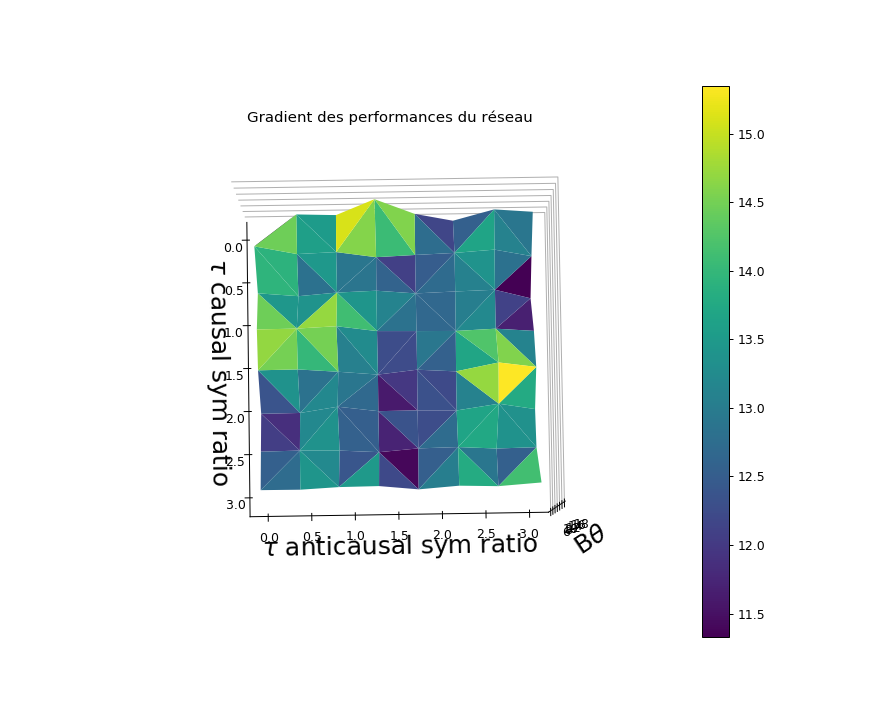

In [32]:
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

scan_size = 8

# ratios are applied as a multiplier of the positive part of STDP
# ie tau_plus or A_plus
parameters_dico = {'causal_ratio': np.array([1.5]),
                   'anticausal_ratio': np.array([0.3]),
                   'causal_sym_ratio': np.array([1]),
                   'anticausal_sym_ratio': np.array([1.75]), 
                   't_causal_ratio': np.array([1.25]),
                   't_anticausal_ratio': np.array([.75]),
                   't_causal_sym_ratio': np.linspace(.01, 3, scan_size),
                   't_anticausal_sym_ratio': np.linspace(.01, 3, scan_size),
                   }
grid = ParameterGrid(parameters_dico)

scan_output = []
for combination in tqdm(grid):
    final_b_theta = run_simulation(causal_ratio=combination['causal_ratio'],
                                   anticausal_ratio=combination['anticausal_ratio'],
                                   causal_sym_ratio=combination['causal_sym_ratio'],
                                   anticausal_sym_ratio=combination['anticausal_sym_ratio'],
                                   t_causal_ratio=combination['t_causal_ratio'],
                                   t_anticausal_ratio=combination['t_anticausal_ratio'],
                                   t_causal_sym_ratio=combination['t_causal_sym_ratio'],
                                   t_anticausal_sym_ratio=combination['t_anticausal_sym_ratio'])
    scan_output.append([final_b_theta, combination])

b_fs, t_causal_sym_ratios, t_anticausal_sym_ratios = [], [], []
for scan in scan_output:
    b_fs.append(scan[0])
    t_causal_sym_ratios.append(scan[1]['t_causal_sym_ratio'])
    t_anticausal_sym_ratios.append(scan[1]['t_anticausal_sym_ratio'])

triD_plot(t_causal_sym_ratios, t_anticausal_sym_ratios, b_fs,
        r'$\tau$ causal sym ratio', r'$\tau$ anticausal sym ratio', r'B$\theta$')
plt.show()

# Et donc les params optimaux 

In [ ]:
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

scan_size = 8

# ratios are applied as a multiplier of the positive part of STDP
# ie tau_plus or A_plus
parameters_dico = {'causal_ratio': np.array([1.5]),
                   'anticausal_ratio': np.array([0.3]),
                   'causal_sym_ratio': np.array([1]),
                   'anticausal_sym_ratio': np.array([1.75]), 
                   't_causal_ratio': np.array([1.25]),
                   't_anticausal_ratio': np.array([.75]),
                   't_causal_sym_ratio': np.array([1.6]),
                   't_anticausal_sym_ratio': np.array([1.25]),
                   }
grid = ParameterGrid(parameters_dico)

scan_output = []
for combination in tqdm(grid):
    final_b_theta = run_simulation(causal_ratio=combination['causal_ratio'],
                                   anticausal_ratio=combination['anticausal_ratio'],
                                   causal_sym_ratio=combination['causal_sym_ratio'],
                                   anticausal_sym_ratio=combination['anticausal_sym_ratio'],
                                   t_causal_ratio=combination['t_causal_ratio'],
                                   t_anticausal_ratio=combination['t_anticausal_ratio'],
                                   t_causal_sym_ratio=combination['t_causal_sym_ratio'],
                                   t_anticausal_sym_ratio=combination['t_anticausal_sym_ratio'])
    scan_output.append([final_b_theta, combination])

b_fs, t_causal_sym_ratios, t_anticausal_sym_ratios = [], [], []
for scan in scan_output:
    b_fs.append(scan[0])
    t_causal_sym_ratios.append(scan[1]['t_causal_sym_ratio'])
    t_anticausal_sym_ratios.append(scan[1]['t_anticausal_sym_ratio'])

triD_plot(t_causal_sym_ratios, t_anticausal_sym_ratios, b_fs,
        r'$\tau$ causal sym ratio', r'$\tau$ anticausal sym ratio', r'B$\theta$')
plt.show()